# Artificial Neural Networks, another atempt

Here I will try to make a neural network using numpy, that is capable of achieving a satisfying accuracy on the mnist dataset of handwritten digits. The model will be supervised and later I will give a potential unsupervised model for solving the same task which (hopefully) yields results similar to the supervised model


## Import necessary utility libraries


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

from matplotlib.pyplot import figure

## Define utility functions

In [3]:
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

def one_hot_encode(x, size = 10):
    arr = np.zeros((size,1))
    arr[x] = 1
    return arr

# Activation functions

def identity(x, d = False):
    if d == False:
        return x
    else:
        ones = np.ones(x.shape)
        return ones
    
def sgn(x, d = False):
    if d == False:
        return np.where(x < 0, -1, 1)
    else:
        return np.where(x != 0, 0, 0)
    
def l_relu(x, d = False):
    if not d:
        return np.where(x > 0, x, x/10)
    else:
        return np.where(x > 0, 1, -1.0/10)

def relu(x, d = False):
    if not d:
        return np.where(x > 0, x, 0)
    else:
        return np.where(x > 0, 1, 0)
    
def sigmoid(x, d = False):
    s = 1. / (1. + np.exp(-x))
    if not d:
        return s
    else:
        return np.multiply(s, (1 - s))

def tanh(x, d = False):
    th = np.tanh(x)
    if not d:
        return 1 - np.power(th, 2)
    else:
        return th
    
# Error function
def error_function(output, expected, d = False, d_out = None):
    if not d:
        error = np.sum(np.matrix( (1/2) * np.sum(np.power(expected - output, 2))))
        return np.nan_to_num(error)
    else:
        error = np.multiply(np.subtract(output, expected), (np.matrix(d_out)))
        return np.nan_to_num(error)
        

[-5 -4 -3 -2 -1  0  1  2  3  4] 

   ReLu   
[0 0 0 0 0 0 1 2 3 4]
[0 0 0 0 0 0 1 1 1 1]


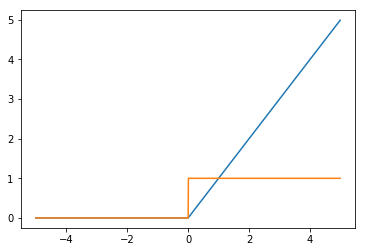

   identity   
[-5 -4 -3 -2 -1  0  1  2  3  4]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.] 



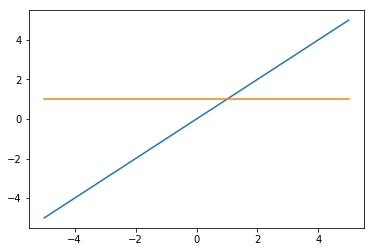

   l_ReLu   
[-0.5 -0.4 -0.3 -0.2 -0.1  0.   1.   2.   3.   4. ]
[-0.1 -0.1 -0.1 -0.1 -0.1 -0.1  1.   1.   1.   1. ] 



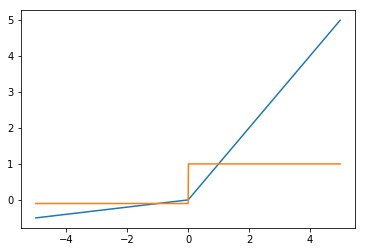

   Sigmoid   
[0.00669285 0.01798621 0.04742587 0.11920292 0.26894142 0.5
 0.73105858 0.88079708 0.95257413 0.98201379]
[0.00664806 0.01766271 0.04517666 0.10499359 0.19661193 0.25
 0.19661193 0.10499359 0.04517666 0.01766271] 



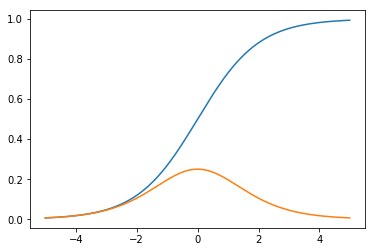

   sgn   
[-1 -1 -1 -1 -1  1  1  1  1  1]
[0 0 0 0 0 0 0 0 0 0] 



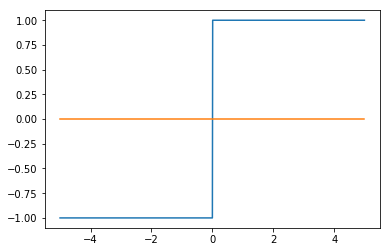

   TanH   
[1.81583231e-04 1.34095068e-03 9.86603717e-03 7.06508249e-02
 4.19974342e-01 1.00000000e+00 4.19974342e-01 7.06508249e-02
 9.86603717e-03 1.34095068e-03]
[-0.9999092  -0.9993293  -0.99505475 -0.96402758 -0.76159416  0.
  0.76159416  0.96402758  0.99505475  0.9993293 ] 



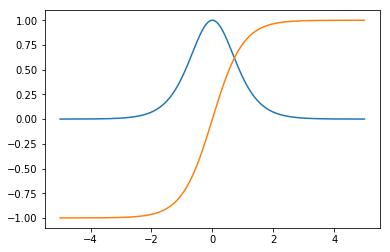

In [4]:
t = np.arange(-5, 5, step = 1)
t_prim = np.arange(-5, 5, step = 0.01)
print(t, "\n")

print("   ReLu   ")
print(relu(t))
print(relu(t, d = True))
plt.plot(t_prim, relu(t_prim))
plt.plot(t_prim, relu(t_prim, d = True))
plt.show()

print("   identity   ")
print(identity(t))
print(identity(t, d = True), "\n")
plt.plot(t_prim, identity(t_prim))
plt.plot(t_prim, identity(t_prim, d = True))
plt.show()

print("   l_ReLu   ")
print(l_relu(t))
print(l_relu(t, d = True), "\n")
plt.plot(t_prim, l_relu(t_prim))
plt.plot(t_prim, l_relu(t_prim, d = True))
plt.show()

print("   Sigmoid   ")
print(sigmoid(t))
print(sigmoid(t, d = True), "\n")
plt.plot(t_prim, sigmoid(t_prim))
plt.plot(t_prim, sigmoid(t_prim, d = True))
plt.show()

# NOT A GOOD CHOICE!
print("   sgn   ")
print(sgn(t))
print(sgn(t, d = True), "\n")
plt.plot(t_prim, sgn(t_prim))
plt.plot(t_prim, sgn(t_prim, d = True))
plt.show()


print("   TanH   ")
print(tanh(t))
print(tanh(t, d = True), "\n")
plt.plot(t_prim, tanh(t_prim))
plt.plot(t_prim, tanh(t_prim, d = True))
plt.show()


## Import the MNIST dataset (handwritten digits)

In [5]:

import tensorflow as tf
mnist = tf.keras.datasets.mnist
(training_examples, training_labels),(test_examples, test_labels) = mnist.load_data()

lab_examples = training_examples

training_examples = normalize(training_examples)
test_examples = normalize(test_examples)


c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
"""
###
Split data into train and test sets
###
"""

num_train = len(training_examples)  # amount of training examples/labels

num_test = len(test_examples)   # amount of test examples/labels

img_len = np.prod((training_examples[0].shape))      # Number of pixels in image

img_dim = (int(math.sqrt(img_len)), int(math.sqrt(img_len))) # Image dimension



training_examples = normalize(np.reshape(training_examples, (num_train, img_len, 1)))
lab_examples = np.reshape(lab_examples, (num_train, img_len, 1))
test_examples = np.reshape(test_examples, (num_test, img_len, 1))
print(training_examples.shape)


print("Number of training examples and test examples: ", num_train, ", ", num_test)
print("data dimensions: ", img_dim)
print("example dimension: ", training_examples[0].shape)



(60000, 784, 1)
Number of training examples and test examples:  60000 ,  10000
data dimensions:  (28, 28)
example dimension:  (784, 1)


Display some training images: 


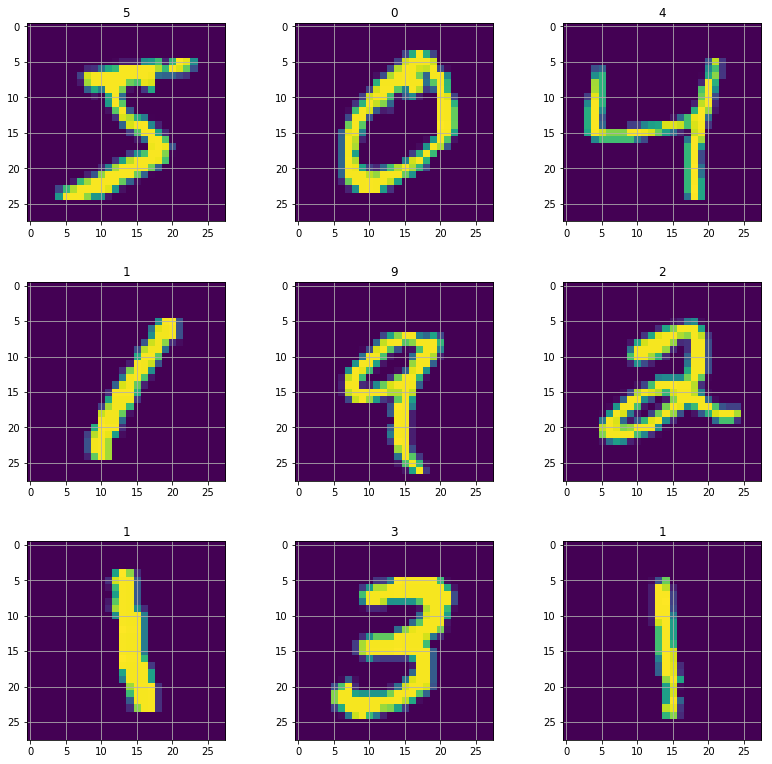

Training and testing distributions: 


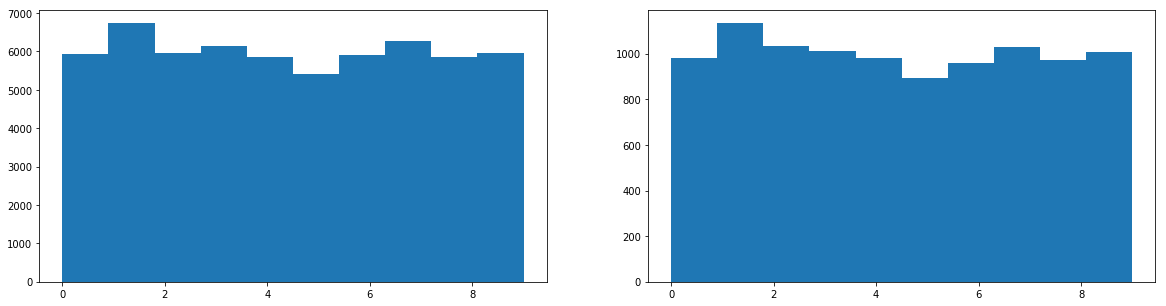

In [7]:
num = 331

print("Display some training images: ")
plt.subplots(figsize=(12,12))
for i in range(9):
    plt.subplot(num + i)
    plt.title(training_labels[i])
    plt.imshow(training_examples[i].reshape(img_dim))    
    plt.grid(True)

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

plt.show()

print("Training and testing distributions: ")
plt.subplots(figsize= (20, 5))
plt.subplot(121)
plt.hist(training_labels)
plt.subplot(122)
plt.hist(test_labels)
plt.show()




# The neural network class

The network takes as input a list of sizes that determines the size of each layer(respective to each int) and a list of functions that work as activation functions for each layer relative to their order.



In [63]:
class neural_net:
    def __init__(self, sizes, activation_functions):
        if len(sizes) < 2:
            print("Invalid size parameters, requires 2(input and output) or more integers(input, hidden and output)")
            return 0
        
        if len(activation_functions) != len(sizes) - 1:
            print("The number of activation functions defined for each layer must be equal to the number of layers(excluding the input layer)!")
            return 0
        
        self.activation_functions = activation_functions
        self.sizes = sizes
        self.biases = np.random.random_sample((len(self.sizes), 1)) * 0.1
        
            
            # Generate random weights
        self.weights = []
        for i, j in zip(self.sizes[:-1], self.sizes[1:]):
            self.weights.append(np.random.random_sample((j, i)) * math.sqrt(2/ (j*i)) * 0.1)
    
        # Feed forwarding for end use
    def feed_forward(self, input_vector):
        signal = input_vector
        
        for w, f, b in zip(self.weights, self.activation_functions, self.biases):
            signal = f(np.dot(w, signal) + b)
            
        return signal
    
        # This is used during training to get the complete set of signals
    def train_feed_forward(self, input_vector, label):
        
            # Gathered signals
        signals = []
        derived_signals = []
        
            # Append input as the first signal
        signals.append(input_vector)
        
            # Might be redundant
        derived_signals.append(self.activation_functions[0](input_vector, d = True))
        
        
            # For every combined weight matrix, activation function and bias
        for w, f, b in zip(self.weights, self.activation_functions, self.biases):
            
                # Save derivative of signal
            derived_signals.append(f(np.dot(w, signals[-1] + b), d = True))
                # Save the signal itself
            signals.append(f(np.dot(w, signals[-1] + b), d = False)) 
            
            # Return 3 things: the signals, the derived signals and the error of the signals
        return signals, derived_signals, error_function(signals[-1], label, d = True, d_out = derived_signals[-1])
    
    def backpropagate(self, signals, d_signals, out_error):

            # Error in each layer
        error_vectors = list() 
        
            # Append error in output layer
        error_vectors.append(np.multiply(out_error, d_signals[-1])) 
        
        for w in reversed(range(len(self.weights))):
                # The error in each hidden layer = W * E * X
                # Where W are the weights we want to change, E is the error in the previous layer
                #  and X is the input signals from the respective layer
            error = np.sum(np.multiply(self.weights[w], error_vectors[-1])) * (np.matrix(d_signals[w]))
            error_vectors.append(error)
            
        return error_vectors
    

        # Basic learning upgrade, not used in batch learning!
    def update_biases(self, d_signals, alpha, errors):
        
        for i in reversed(range(len(self.weights))):
            self.biases[i] = self.biases[i] - np.sum((alpha) * np.multiply(d_signals[i], errors[i]))
        
         # Basic learning upgrade, not used in batch learning!
    def update_weights(self, errors, signals, alpha):
        
            # The weights connecting to output are changed like this
        self.weights[-1] = self.weights[-1] - (alpha) * errors[0]
        
            # The other ones like so: weight = weight - learning_rate * error * input
        for w in range(len(self.weights)-1):
                
            alp = (alpha) * np.multiply(errors[-(w + 1)], signals[w])
            
                # alp will be a 1D matrix, flatten it to be a vector!
            self.weights[w] = self.weights[w] - alp.flatten()
            
      
        # Store the summed changes in a batch
    def gradient_of_weights(self, errors, signals, alpha):
        
            # List with changes in one iteration
        grad_weights = []
        for i, j in zip(self.sizes[:-1], self.sizes[1:]):
            grad_weights.append(np.zeros((j, i)))
            
        grad_weights[-1] = (self.weights[-1] - (alpha * errors[0]))
        
            # The other ones like so: weight = weight - learning_rate * error * input
        for w in range(len(self.weights)-1):
                
            alp = (alpha) * np.multiply(errors[-(w + 1)], signals[w])
            
                # alp will be a 1D matrix, flatten it to be a vector!
            grad_weights[w] = self.weights[w] - alp.flatten()
            
        return grad_weights
    
        # Store the summed changes in a batch
    def gradient_of_biases(self, errors, d_signals, alpha):
        
        gradient_biases = np.zeros((len(self.sizes), 1))
        for i in range(len(self.weights)):
            gradient_biases[i] = self.biases[i] - np.sum((alpha) * np.multiply(d_signals[i], errors[- (i + 1)]))
        
        return gradient_biases
        
    def update_weights_with_gradient(self, grad):
        
        for w in range(len(self.weights)):
            self.weights[w] = grad[w]
            
    def update_biases_with_gradient(self, grad):
        
        for b in range(len(self.biases)):
            self.biases[b] = grad[b]
    
    def train(self, input_vector, label, alpha = 0.001):
        
        
            # Feed input through network, returns the signals and error
        signals, d_signals, output_error = self.train_feed_forward(input_vector, label)
        
            # Perform backpropagation
        errors = self.backpropagate(signals, d_signals, output_error)
        
            # Update weights
        self.update_biases(d_signals, alpha, errors)
        
            # Update the weights based on error from backpropagation
        self.update_weights(errors, signals, alpha)
            
            # return the output of the error function
        return error_function(signals[-1], label)
    
    
    def batch_training(self, data, labels, alpha = 0.0001, batch_size = 16, epochs = 1, overfit = False, display = False, display_step = 1000):
        
        
        counter = 0
        display_counter = 0
        
        errs = []
        summed_gradient_biases = np.zeros((len(self.sizes), 1))
        summed_gradient_weights = []
        for i, j in zip(self.sizes[:-1], self.sizes[1:]):
            summed_gradient_weights.append(np.zeros((j, i)))

        
        for e in range(epochs):
            
            for d, l in zip(data, labels):

                if overfit:
                    d = data[0]
                    l = labels[0]

                    # Feed input through network, returns the signals and error
                signals, d_signals, out_error = self.train_feed_forward(d, l)
                
                    # Save errors in order to plot them later
                errs.append(error_function(signals[-1], l))

                     # Perform backpropagation
                errors = self.backpropagate(signals, d_signals, out_error)
                
                    # Store each error in a list
                gow = self.gradient_of_weights(errors, signals, alpha)
                gob = self.gradient_of_biases(errors, d_signals, alpha)
                
                for i in range(len(summed_gradient_weights)):
                    summed_gradient_weights[i] = summed_gradient_weights[i] + (gow[i] / batch_size)
                
                for i in range(len(summed_gradient_biases)):
                    summed_gradient_biases[i] = summed_gradient_biases[i] + (gob[i] / batch_size)
                
                counter += 1

                     # When we have iterated thorugh a batch, update the network
                if counter == batch_size:
                    
                        # Update biases in network
                    self.update_biases_with_gradient(summed_gradient_biases)
                    
                        # Update weights in network 
                    self.update_weights_with_gradient(summed_gradient_weights)
                    
                        # Reset counter and start on the next batch
                    counter = 0
                    
                    summed_gradient_biases = np.zeros((len(self.sizes), 1))
                    summed_gradient_weights = []
                    for i, j in zip(self.sizes[:-1], self.sizes[1:]):
                        summed_gradient_weights.append(np.zeros((j, i)))
                
                display_counter += 1
                
                    # Display signals
                if display_counter == display_step:
                    display_counter = 0
                    if display:
                        displayMe(signals, error_function(signals[-1], l), self.sizes)
                        
                
        plt.subplots(figsize=(30,30))
        plt.plot(errs)
        plt.show()
        
        return error_function(signals[-1], l)

# Method for learning process

displayMe will show an image of the activations to display the networks accuracy. Does not work if the number of neurons in a givn layer is not a perfect square

In [9]:
def displayMe(signals, title, sizes):
    
    num = 191
    plt.subplots(figsize=(30,3))
    
    for i in range(len(signals)):
        plt.subplot(num)
        num += 1
        dim_int = int(math.sqrt(sizes[i]))
        dim = (dim_int, dim_int)
        plt.imshow(signals[i].reshape(dim))    

    plt.suptitle("Summed error: " + str(title))
    plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)

    plt.show()
    
    

# Using the model 

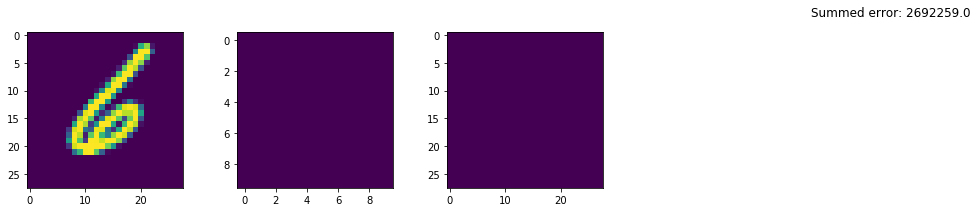

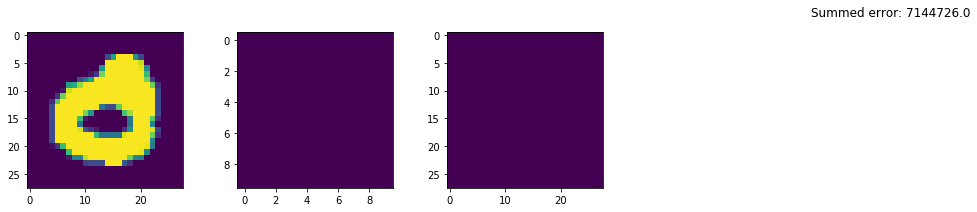

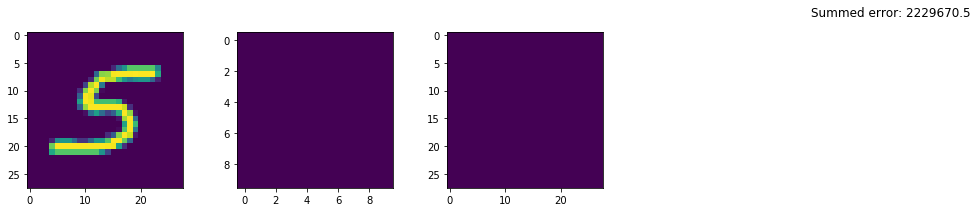

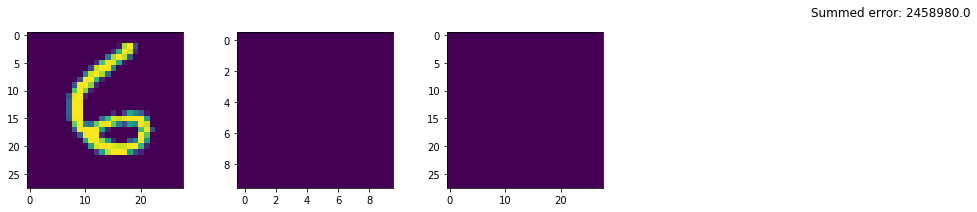

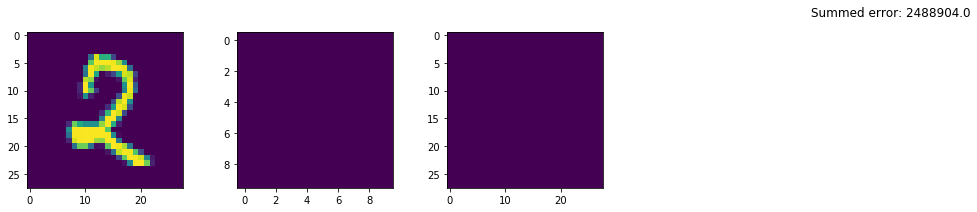

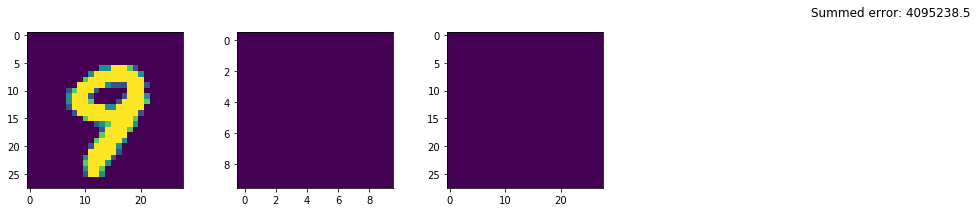

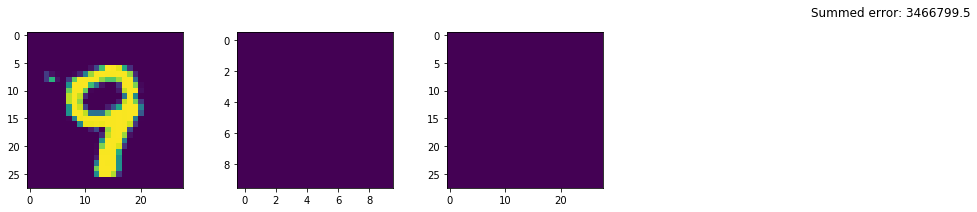

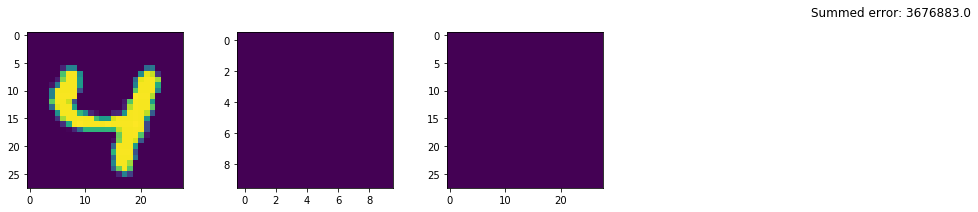

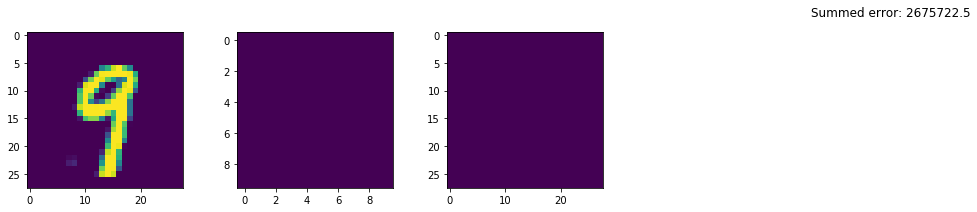

KeyboardInterrupt: 

In [66]:

sizes = [784, 10 * 10,  784]
input_shape = (sizes[0], 1)
a_functions = []
[a_functions.append(sigmoid) for i in range(1, len(sizes))]


net = neural_net(sizes, a_functions)

net.batch_training(data = training_examples, 
                   labels = lab_examples, 
                   alpha = 0.00001, 
                   batch_size = 32, 
                   epochs = 1,
                   overfit = False,
                   display = True,
                   display_step = 1000)


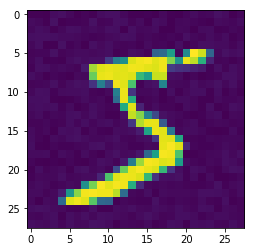

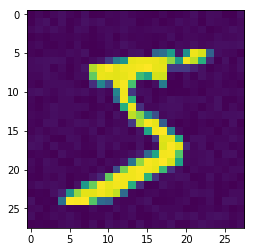

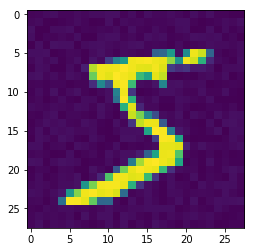

In [45]:
plt.imshow(net.weights[0][0].reshape(img_dim))
plt.show()
plt.imshow(net.weights[0][10].reshape(img_dim))
plt.show()
plt.imshow(net.weights[0][90].reshape(img_dim))
plt.show()

# Test if the network can learn basic operations like addition
For these examples, if the weights become optimal by assuming certain values.
For example: Adding the two numbers means that the weight simply must assume the value 1,
if the backprpagation algorithm is implemented correctly, then the weights should converge to 1
quickly (relative to the learning rate of course)


In [46]:
# Generate dummy data
t_e = [ -10000 * np.random.random_sample((2, 1)) + 5000 for i in range(2000)]
l_e = [np.sum(e) for e in t_e]

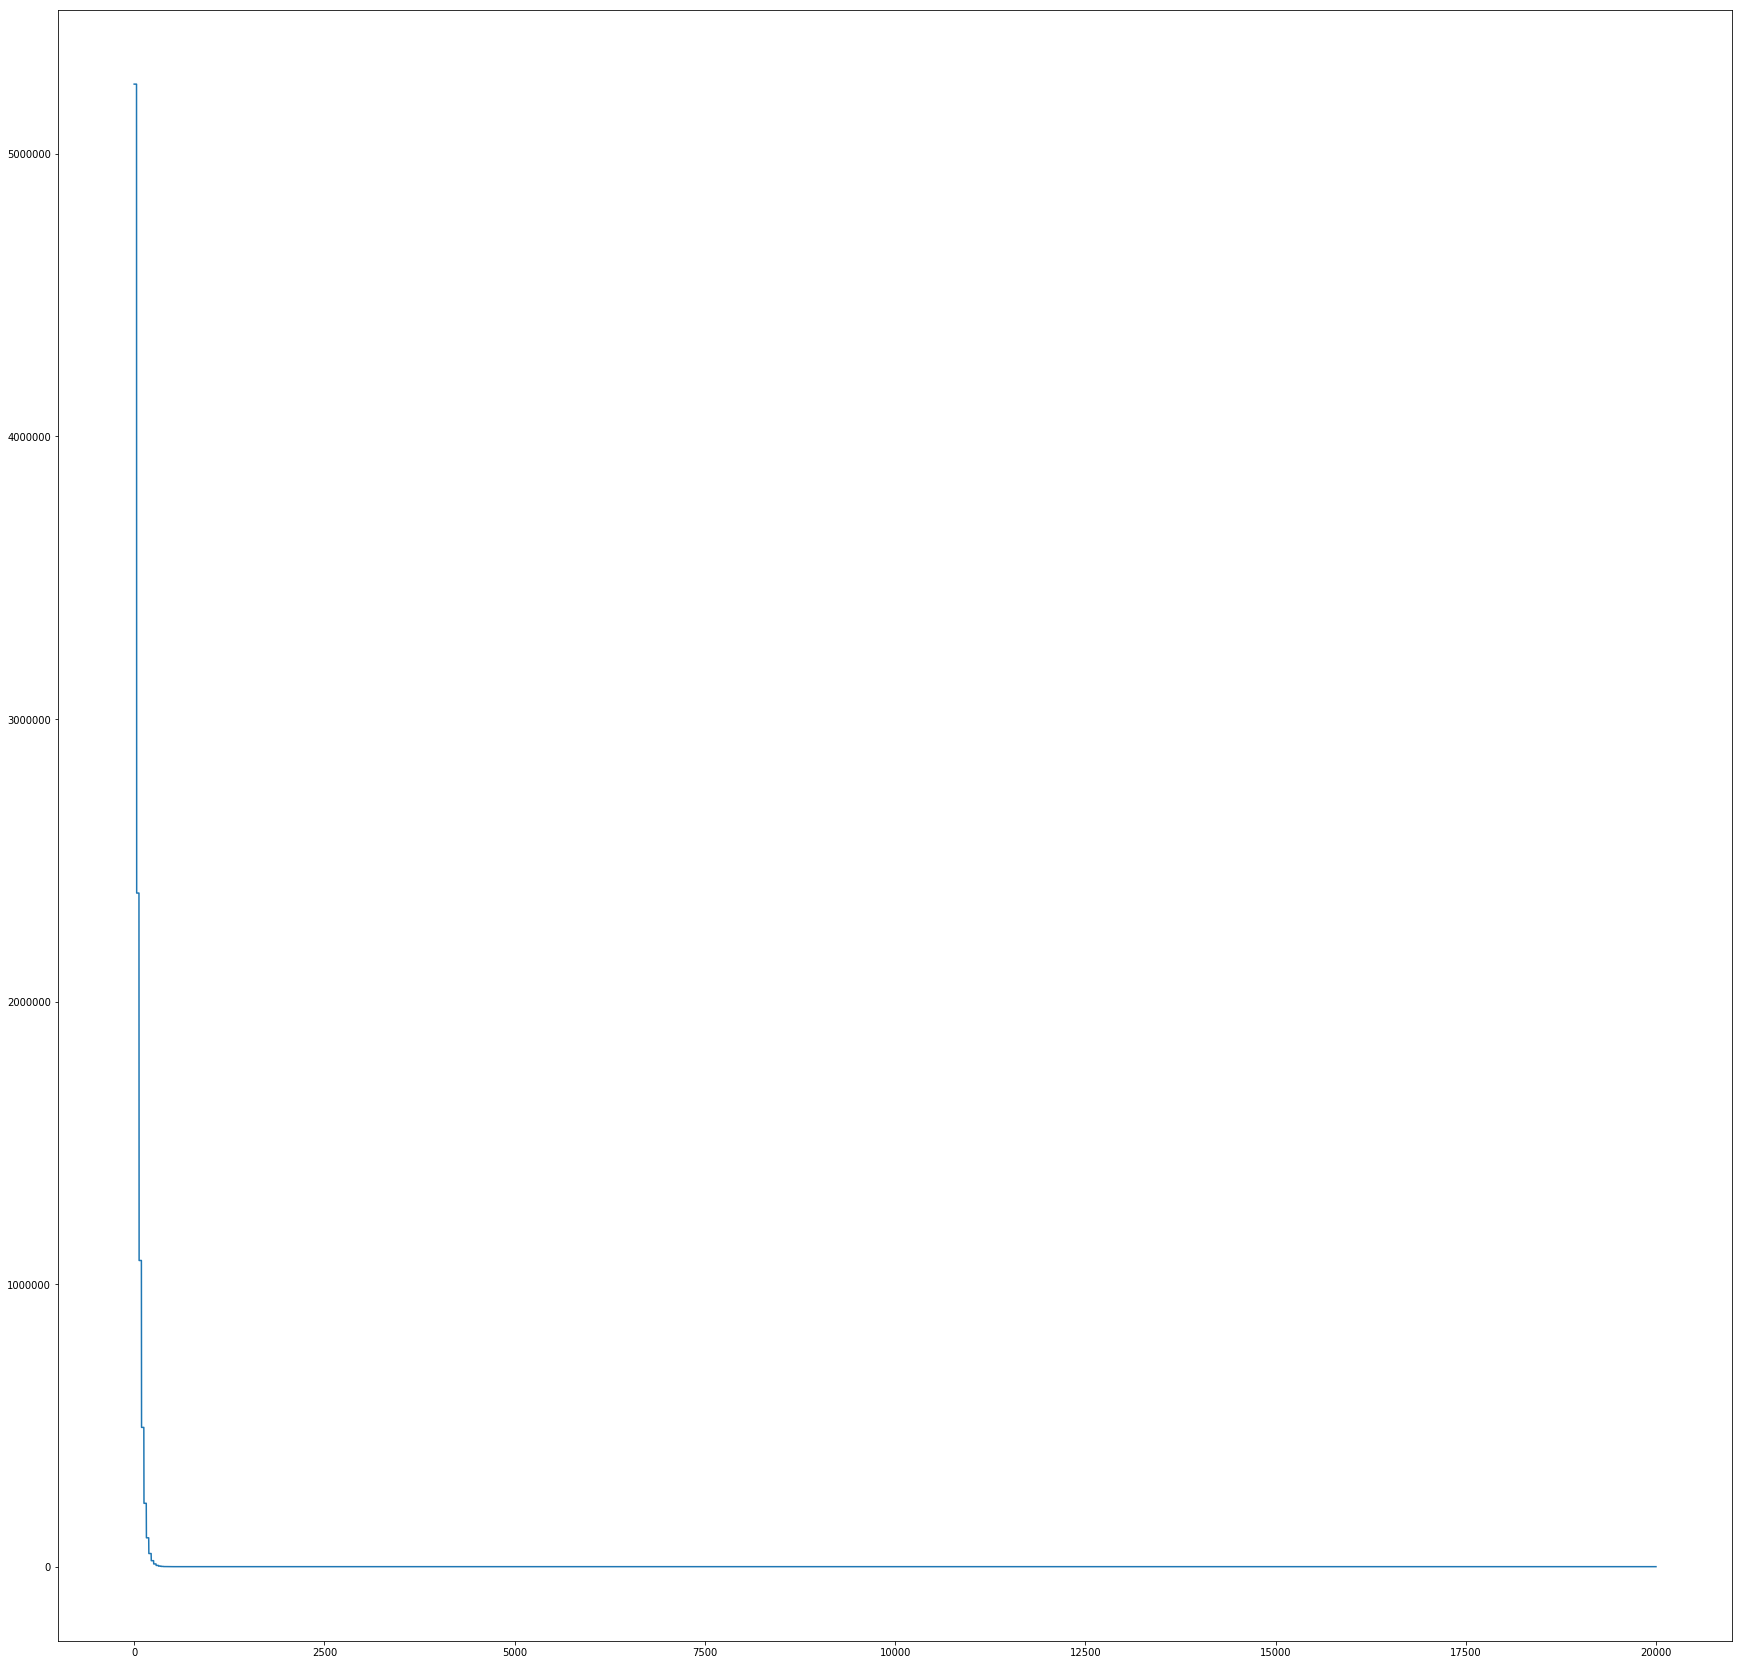

[[-3261.2933117]]
-3259.580596408936
[matrix([[1.0002761 , 1.00110429]])]


In [47]:
s = [2, 1]
a_f = [identity]

alpha = 0.0001
epochs = 10
mini_batch_size = 32

n = neural_net(s, a_f)

n.batch_training(t_e, l_e, alpha = alpha, batch_size = mini_batch_size, epochs = epochs, overfit= True, display = False)

sig = n.feed_forward(t_e[0])
print(sig)
print(l_e[0])

print(n.weights)
        

        

In [367]:
from mpl_toolkits.mplot3d import Axes3D

x_vals = np.arange(-1.0, 2.0, step = 0.1)
y_vals = np.arange(-1.0, 2.0, step = 0.1)


Weight before training:  [array([[0.05924144]])]
input with 4:  [[0.33522338]]
input with 5:  [[0.39446482]]
input with 6:  [[0.45370626]]
input with 7:  [[0.51294771]]
input with 50:  [[3.06032977]]


c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in power
c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in multiply
c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in subtract
c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:127: RuntimeWarning: overflow encountered in add
c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in multiply
c:\users\joels\appdata\local\programs\python\python36\lib\site-packages\matplotlib\axes\_base.py:2338: RuntimeWarning: overflow encountered in double_scalars
  x1t += delta


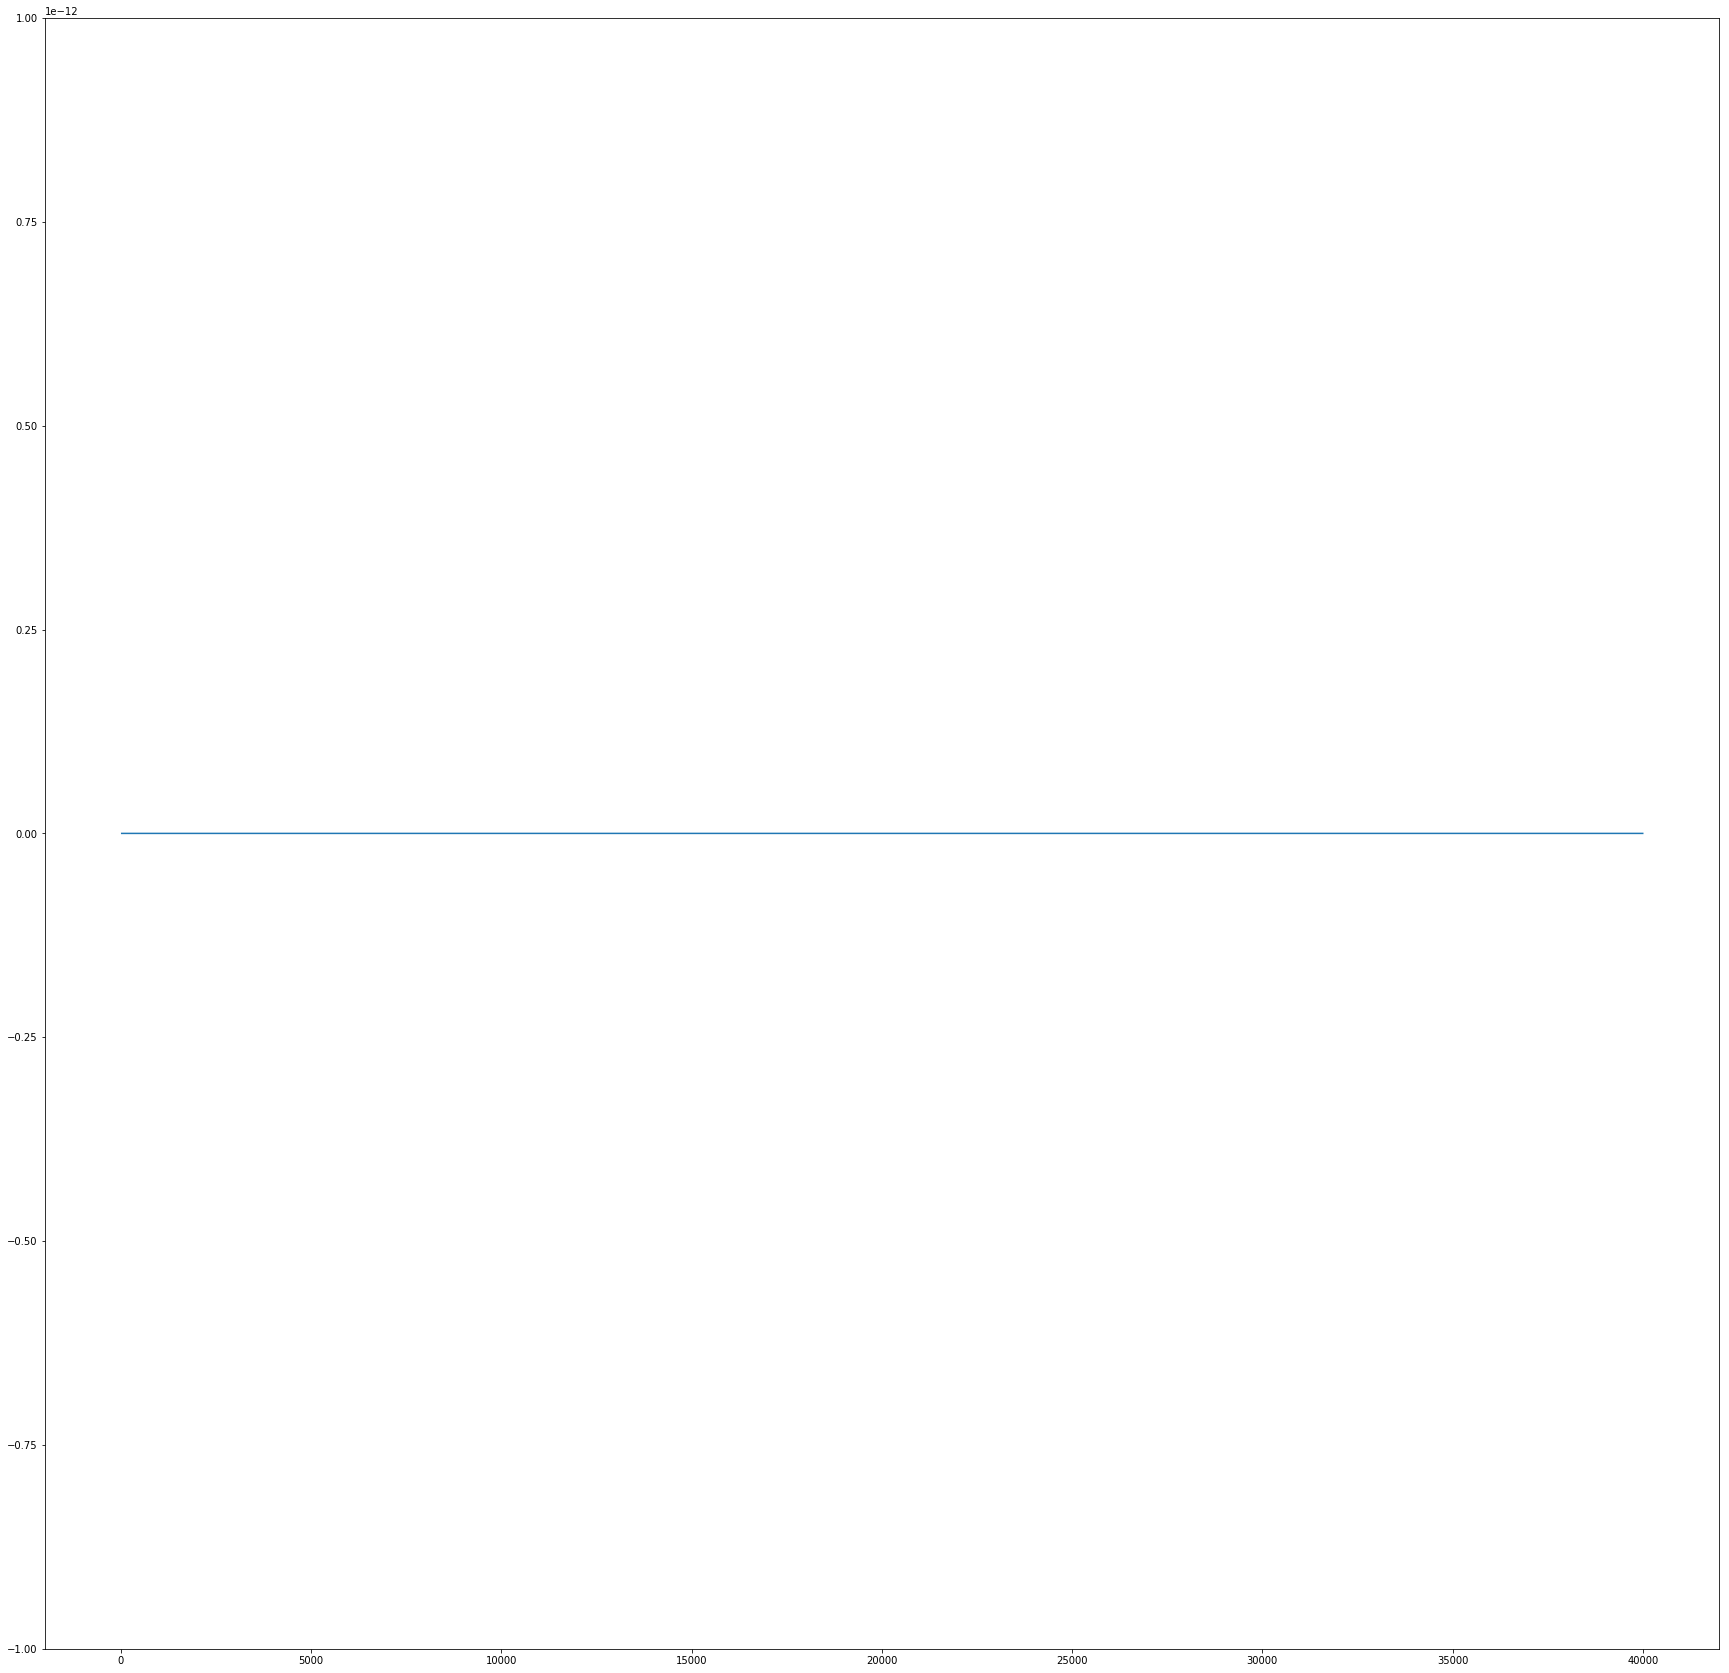


input with 4:  [[nan]]
input with 5:  [[nan]]
input with 6:  [[nan]]
input with 7:  [[nan]]
input with 50:  [[nan]]
Weight after training:  [array([[-inf]])]
Final error:  0.0


In [64]:
s = [1, 1]
a_f = [identity]

alpha = 0.001
epochs = 4
mini_batch_size = 1

n = neural_net(s, a_f)

print("Weight before training: ", n.weights)

print("input with 4: ", n.feed_forward(4))
print("input with 5: ", n.feed_forward(5))
print("input with 6: ", n.feed_forward(6))
print("input with 7: ", n.feed_forward(7))
print("input with 50: ", n.feed_forward(50))

iters = 10000
ex = np.ones(iters)

error = n.batch_training(ex, ex, alpha = alpha, batch_size = mini_batch_size, epochs = epochs, overfit= True, display = False)



print()
print("input with 4: ", n.feed_forward(4))
print("input with 5: ", n.feed_forward(5))
print("input with 6: ", n.feed_forward(6))
print("input with 7: ", n.feed_forward(7))
print("input with 50: ", n.feed_forward(50))
print("Weight after training: ", n.weights)
print("Final error: ", error)